<a href="https://colab.research.google.com/github/sgami444/Spotify-country-wise-trends-Data-mining/blob/main/WeightedKmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import time

In [ ]:
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import plotly.express as px
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv("Spotify.csv", sep='\t')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(inplace=True)

In [ ]:
df.head(), df.shape

(                track_url        country  acousticness  danceability  energy  \
 0  5Z9KJZvQzH6PFmb8SNkxuk  United States      0.022100         0.741   0.691   
 1  5PjdY0CKGZdEuoNab3yDmX  United States      0.038300         0.591   0.764   
 2  0k1WUmIRnG3xU6fvvDVfRG  United States      0.000619         0.803   0.597   
 3  2BcMwX1MPV6ZHP4tUT9uq6  United States      0.063500         0.849   0.424   
 4  02MWAaffLxlfxAUY7c5dvx  United States      0.440000         0.761   0.525   
 
    instrumentalness   key  liveness  loudness  speechiness    tempo  valence  
 0          0.000000  10.0    0.0476    -7.395       0.0672  150.087    0.892  
 1          0.000000   1.0    0.1030    -5.484       0.0483  169.928    0.478  
 2          0.000005  11.0    0.3230    -6.035       0.1410  136.008    0.331  
 3          0.000000   5.0    0.0834    -9.579       0.3240  145.887    0.153  
 4          0.000007  11.0    0.0921    -6.900       0.0944   80.870    0.531  ,
 (12812, 12))

In [ ]:
df.iloc[:,2:].corr()

acousticness  danceability    energy  instrumentalness  \
acousticness          1.000000     -0.295140 -0.595945         -0.013199   
danceability         -0.295140      1.000000  0.242724         -0.077598   
energy               -0.595945      0.242724  1.000000          0.031971   
instrumentalness     -0.013199     -0.077598  0.031971          1.000000   
key                   0.003973      0.076585  0.049790          0.020529   
liveness             -0.044064     -0.064496  0.116350         -0.010378   
loudness             -0.397237      0.209828  0.687410         -0.130839   
speechiness          -0.039030      0.229325  0.026419         -0.057400   
tempo                -0.070060     -0.131783  0.111195          0.033012   
valence              -0.274648      0.435826  0.466552         -0.080678   

                       key  liveness  loudness  speechiness     tempo  \
acousticness      0.003973 -0.044064 -0.397237    -0.039030 -0.070060   
danceability      0.076585 -0.064496  0.209828     0.229325 -0.131783   
energy            0.049790  0.116350  0.687410     0.026419  0.111195   
instrumentalness  0.020529 -0.010378 -0.130839    -0.057400  0.033012   
key               1.000000  0.018934  0.032227     0.008562 -0.002025   
liveness          0.018934  1.000000  0.067013     0.032467 -0.007974   
loudness          0.032227  0.067013  1.000000    -0.068360  0.061397   
speechiness       0.008562  0.032467 -0.068360     1.000000  0.119245   
tempo            -0.002025 -0.007974  0.061397     0.119245  1.000000   
valence           0.084624  0.043514  0.399427     0.070101  0.016397   

                   valence  
acousticness     -0.274648  
danceability      0.435826  
energy            0.466552  
instrumentalness -0.080678  
key               0.084624  
liveness          0.043514  
loudness          0.399427  
speechiness       0.070101  
tempo             0.016397  
valence           1.000000

### Scaling Data

In [ ]:
scaler = MinMaxScaler()
arr = np.array(df.iloc[:,2:])
arr_scaled = scaler.fit_transform(arr)
df.iloc[:,2:] = arr_scaled

### Data Prep

In [ ]:
df['weights'] = df['danceability']
df.drop('danceability',axis=1, inplace=True)
df.head()

track_url        country  acousticness    energy  \
0  5Z9KJZvQzH6PFmb8SNkxuk  United States      0.022333  0.684038   
1  5PjdY0CKGZdEuoNab3yDmX  United States      0.038714  0.758925   
2  0k1WUmIRnG3xU6fvvDVfRG  United States      0.000613  0.587608   
3  2BcMwX1MPV6ZHP4tUT9uq6  United States      0.064194  0.410135   
4  02MWAaffLxlfxAUY7c5dvx  United States      0.444887  0.513746   

   instrumentalness       key  liveness  loudness  speechiness     tempo  \
0          0.000000  0.909091  0.034254  0.587044     0.059962  0.565748   
1          0.000000  0.090909  0.091758  0.671891     0.034206  0.676482   
2          0.000005  1.000000  0.320116  0.647427     0.160534  0.487172   
3          0.000000  0.454545  0.071414  0.490077     0.409921  0.542307   
4          0.000007  1.000000  0.080444  0.609022     0.097029  0.179443   

    valence   weights  
0  0.908840  0.720046  
1  0.470002  0.547235  
2  0.314183  0.791475  
3  0.125503  0.844470  
4  0.526182  0.743088

### K_Means

In [ ]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro, boxcox

In [ ]:
pca = PCA(n_components = 3)
W = pca.fit_transform(df.iloc[:,2:-1])
weights = np.array(df.weights)

In [ ]:
def compute_l2_distance(x, centroid):
    # Compute the difference, following by raising to power 2 and summing
    dist = ((x - centroid) ** 2).sum(axis = x.ndim - 1)
    return dist

def compute_distance_scipy(data, centroid, metric):
    dist = cdist(data, centroid, metric)
    return dist

def get_closest_centroid(x, centroids):
    # Loop over each centroid and compute the distance from data point.
    dist = compute_l2_distance(x, centroids)
    # Get the index of the centroid with the smallest distance to the data point 
    closest_centroid_index =  np.argmin(dist, axis = 1)
    return closest_centroid_index

def get_closest_centroid_scipy(data, centroids, metric):
    dist = compute_distance_scipy(data, centroids, metric)
    closest_centroid_index = [np.argmin(i) for i in dist]
    return closest_centroid_index

def compute_sse(data, centroids, assigned_centroids):
    # Initialise SSE 
    sse = 0
    # Compute SSE
    sse = compute_l2_distance(data, centroids[assigned_centroids]).sum() / len(data)
    return sse

def fit(data, weights, k, max_iter, random_seed):
    random.seed(random_seed)
    # Initialise centroids
    centroids = data[random.sample(range(data.shape[0]), k)]
    # Create a list to store which centroid is assigned to each row item
    assigned_centroids = np.zeros(len(data), dtype = np.int32)
    # Number of dimensions in centroid
    num_centroid_dims = data.shape[1]
    # List to store SSE (sum of squared errors) for each iteration 
    sse_list = []
    for n in range(max_iter):
        # Get closest centroids to each data point
        assigned_centroids = get_closest_centroid(data[:, None, :], centroids[None,:, :]) 
        # assigned_centroids_2 = get_closest_centroid_scipy(data, centroids,'euclidean')
        # Compute new centroids
        for c in range(centroids.shape[0]):
            # get all data points belonging to each of the cluster 
            cluster_members = data[assigned_centroids == c]
            # get mean of cluster 
#             cluster_members = cluster_members.mean(axis = 0)
            cluster_members = np.average(cluster_members, weights= weights[assigned_centroids==c], axis=0)
            # Update the centroids
            centroids[c] = cluster_members

        # Compute SSE
        sse = compute_sse(data.squeeze(), centroids.squeeze(), assigned_centroids)
        sse_list.append(sse)
        if len(sse_list)>2:
            if ((sse == sse_list[-2])):
                print("iterations to converge: ", n)
                break
        else:
            pass
    return centroids, assigned_centroids, sse_list[-1]

def transform(data, centroids, metric):
    labels = get_closest_centroid_scipy(data, centroids, metric)
    return labels

def find_optimal_clusters(clusterer, data, weights, min_clusters, max_clusters, max_iter, random_seed, mode = 'manual'):
    silhouette = []
    sse_list = []
    for i in range(min_clusters, max_clusters+1,1):
        centroids, assigned_centroids, sse = clusterer(data, weights, i, max_iter, random_seed)
        silhouette_avg = silhouette_score(W, assigned_centroids)
        silhouette.append(silhouette_avg)
        sse_list.append(sse)
    if mode == 'manual':
        x = list(range(min_clusters, max_clusters+1,1))
        kn = None
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(x, silhouette, 'g-')
        ax2.plot(x, sse_list, 'b-')
        ax1.set_xlabel('No. of clusters')
        ax1.set_ylabel('sihouette score', color='g')
        ax2.set_ylabel('sse', color='b')
        plt.xticks(x)
        plt.show()
    elif mode == 'auto':
        x = list(range(min_clusters, max_clusters+1,1))
        kl = KneeLocator(x, sse_list, curve = 'convex', direction='decreasing')
        kn = int(kl.knee)
        print("Optimal clusters are ", kn)
    else:
        print("please pass a valid mode type")
    return silhouette, sse_list, kn

In [ ]:
silhouette, sse_list, kn = find_optimal_clusters(fit, W,weights, 2, 20, 100,5, 'auto')
centroids, labels, score = fit(W, weights, kn, 100, 0)

iterations to converge:  15
iterations to converge:  16
iterations to converge:  18
iterations to converge:  40
iterations to converge:  34
iterations to converge:  26
iterations to converge:  39
iterations to converge:  44
iterations to converge:  25
iterations to converge:  24
iterations to converge:  28
iterations to converge:  25
iterations to converge:  20
iterations to converge:  32
iterations to converge:  15
iterations to converge:  24
iterations to converge:  19
iterations to converge:  28
iterations to converge:  36
Optimal clusters are  7
iterations to converge:  13


In [ ]:
print(silhouette)
print(sse_list)
print(kn)
print(centroids)
print(labels)
print(score)

[0.32856841136769127, 0.3566677639253361, 0.31510385162870275, 0.28701620795841026, 0.28164043750141304, 0.2757550177904192, 0.2741898436501974, 0.2795072630624132, 0.28947841384019013, 0.287374120615282, 0.2828509588662875, 0.2775869082353351, 0.2742962181759322, 0.2847645250267341, 0.2774998550180346, 0.28442299070857174, 0.2671668786448231, 0.2725822900638667, 0.27268379505105955]
[0.16880763760532622, 0.11686915869808218, 0.10068952940272549, 0.08643327975348636, 0.07317460247734825, 0.06540047691954191, 0.061636394608359256, 0.05632669322698431, 0.051403166513533695, 0.0478560736274784, 0.04589711968797294, 0.044003154966216304, 0.04255232341979398, 0.03976225005534912, 0.03809069578545732, 0.036117438511180155, 0.03668204765173099, 0.03486926020728177, 0.03274364189128114]
7
[[ 0.43950695  0.33808174  0.11713903]
 [-0.41172587 -0.1352121   0.05627833]
 [-0.12788247  0.50913001  0.06812808]
 [ 0.33531815 -0.11377001 -0.19619655]
 [ 0.16811096 -0.37400937  0.12883614]
 [-0.09626045

iterations to converge:  15
iterations to converge:  16
iterations to converge:  18
iterations to converge:  40
iterations to converge:  34
iterations to converge:  26
iterations to converge:  39
iterations to converge:  44
iterations to converge:  25
iterations to converge:  24
iterations to converge:  28
iterations to converge:  25
iterations to converge:  20
iterations to converge:  32
iterations to converge:  15
iterations to converge:  24
iterations to converge:  19
iterations to converge:  28
iterations to converge:  36


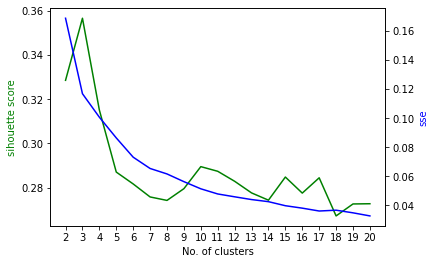

In [ ]:
silhouette, sse_list, kn = find_optimal_clusters(fit, W,weights, 2, 20, 100,5, 'manual')

In [ ]:
centroids, labels, sse = fit(W,weights,3,100,5)

iterations to converge:  16


In [ ]:
pca_out = pd.DataFrame(W, columns = ['comp_x','comp_y', 'comp_z'])
pca_out['labels'] = labels

In [ ]:
fig = px.scatter_3d(pca_out, x='comp_x', y='comp_y', z='comp_z', color='labels')
fig.show()

In [ ]:
df['labels'] = labels

In [ ]:
df.head()

track_url        country  acousticness    energy  \
0  5Z9KJZvQzH6PFmb8SNkxuk  United States      0.022333  0.684038   
1  5PjdY0CKGZdEuoNab3yDmX  United States      0.038714  0.758925   
2  0k1WUmIRnG3xU6fvvDVfRG  United States      0.000613  0.587608   
3  2BcMwX1MPV6ZHP4tUT9uq6  United States      0.064194  0.410135   
4  02MWAaffLxlfxAUY7c5dvx  United States      0.444887  0.513746   

   instrumentalness       key  liveness  loudness  speechiness     tempo  \
0          0.000000  0.909091  0.034254  0.587044     0.059962  0.565748   
1          0.000000  0.090909  0.091758  0.671891     0.034206  0.676482   
2          0.000005  1.000000  0.320116  0.647427     0.160534  0.487172   
3          0.000000  0.454545  0.071414  0.490077     0.409921  0.542307   
4          0.000007  1.000000  0.080444  0.609022     0.097029  0.179443   

    valence   weights  labels  
0  0.908840  0.720046       2  
1  0.470002  0.547235       0  
2  0.314183  0.791475       2  
3  0.125503  0.844470       1  
4  0.526182  0.743088       2

In [ ]:
df.iloc[:,2:-1] = scaler.fit_transform(df.iloc[:,2:-1])

In [ ]:
df_0 = df[df.labels==0]
df_1 = df[df.labels==1]
df_2 = df[df.labels==2]

<AxesSubplot:xlabel='features'>

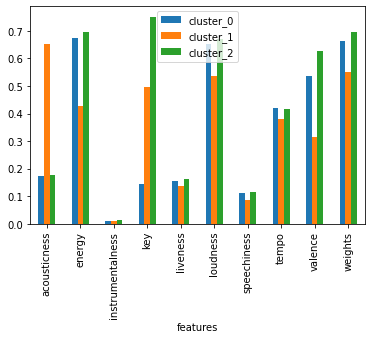

In [ ]:
#pd.merge(pd.DataFrame(df_0.describe().loc['mean']),pd.DataFrame(df_1.describe().loc['mean']), left_index=True, right_index=True, how='left')
mean_clusters = pd.concat([pd.DataFrame(df_0.describe().loc['mean']),pd.DataFrame(df_1.describe().loc['mean']),pd.DataFrame(df_2.describe().loc['mean'])], axis=1).reset_index()
mean_clusters.columns = ['features','cluster_0', 'cluster_1', 'cluster_2']
mean_clusters.iloc[:-1,:].plot(x='features',y=['cluster_0', 'cluster_1', 'cluster_2'], kind='bar')

<AxesSubplot:xlabel='features'>

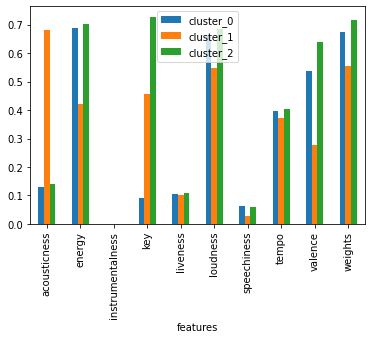

In [ ]:
#pd.merge(pd.DataFrame(df_0.describe().loc['mean']),pd.DataFrame(df_1.describe().loc['mean']), left_index=True, right_index=True, how='left')
mean_clusters = pd.concat([pd.DataFrame(df_0.describe().loc['50%']),pd.DataFrame(df_1.describe().loc['50%']),pd.DataFrame(df_2.describe().loc['50%'])], axis=1).reset_index()
mean_clusters.columns = ['features','cluster_0', 'cluster_1', 'cluster_2']
mean_clusters.iloc[:-1,:].plot(x='features',y=['cluster_0', 'cluster_1', 'cluster_2'], kind='bar')

<AxesSubplot:xlabel='features'>

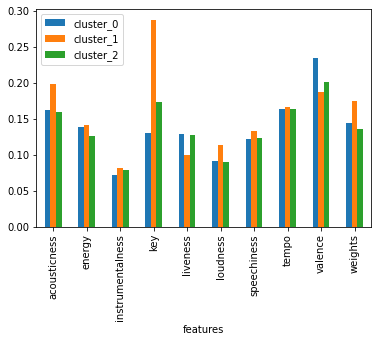

In [ ]:
#pd.merge(pd.DataFrame(df_0.describe().loc['mean']),pd.DataFrame(df_1.describe().loc['mean']), left_index=True, right_index=True, how='left')
mean_clusters = pd.concat([pd.DataFrame(df_0.describe().loc['std']),pd.DataFrame(df_1.describe().loc['std']),pd.DataFrame(df_2.describe().loc['std'])], axis=1).reset_index()
mean_clusters.columns = ['features','cluster_0', 'cluster_1', 'cluster_2']
mean_clusters.iloc[:-1,:].plot(x='features',y=['cluster_0', 'cluster_1', 'cluster_2'], kind='bar')

<AxesSubplot:xlabel='features'>

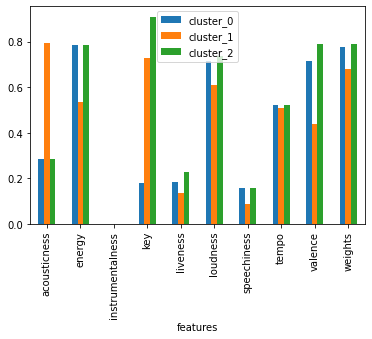

In [ ]:
#pd.merge(pd.DataFrame(df_0.describe().loc['mean']),pd.DataFrame(df_1.describe().loc['mean']), left_index=True, right_index=True, how='left')
mean_clusters = pd.concat([pd.DataFrame(df_0.describe().loc['75%']),pd.DataFrame(df_1.describe().loc['75%']),pd.DataFrame(df_2.describe().loc['75%'])], axis=1).reset_index()
mean_clusters.columns = ['features','cluster_0', 'cluster_1', 'cluster_2']
mean_clusters.iloc[:-1,:].plot(x='features',y=['cluster_0', 'cluster_1', 'cluster_2'], kind='bar')

In [ ]:
df_0.describe()

acousticness       energy  instrumentalness          key     liveness  \
count   4626.000000  4626.000000       4626.000000  4626.000000  4626.000000   
mean       0.174491     0.675869          0.009095     0.144598     0.155436   
std        0.163174     0.139148          0.072090     0.131019     0.129648   
min        0.000000     0.250103          0.000000     0.000000     0.000000   
25%        0.034366     0.575297          0.000000     0.090909     0.080963   
50%        0.128907     0.688141          0.000000     0.090909     0.104214   
75%        0.284116     0.786623          0.000066     0.181818     0.182064   
max        0.834174     0.988716          0.964169     0.454545     0.998962   

          loudness  speechiness        tempo      valence      weights  labels  
count  4626.000000  4626.000000  4626.000000  4626.000000  4626.000000  4626.0  
mean      0.652790     0.113137     0.418774     0.537800     0.664638     0.0  
std       0.092016     0.122414     0.164116     0.234954     0.145007     0.0  
min       0.043111     0.001090     0.096435     0.005406     0.082949     0.0  
25%       0.607601     0.026983     0.275136     0.383082     0.563364     0.0  
50%       0.660836     0.063573     0.398293     0.537842     0.675115     0.0  
75%       0.715136     0.156446     0.523332     0.716981     0.778802     0.0  
max       0.979665     0.871900     1.000000     0.995760     0.989631     0.0

In [ ]:
df_1.describe()

acousticness       energy  instrumentalness          key     liveness  \
count   2640.000000  2640.000000       2640.000000  2640.000000  2640.000000   
mean       0.653219     0.427748          0.012364     0.496212     0.136585   
std        0.199052     0.142313          0.081745     0.287814     0.100621   
min        0.021626     0.000000          0.000000     0.000000     0.022940   
25%        0.529822     0.322938          0.000000     0.272727     0.088229   
50%        0.681492     0.420394          0.000000     0.454545     0.103176   
75%        0.793728     0.537341          0.000059     0.727273     0.136392   
max        1.000000     0.833812          1.000000     1.000000     1.000000   

          loudness  speechiness        tempo      valence      weights  labels  
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000  2640.0  
mean      0.536330     0.086524     0.381297     0.314579     0.549534     1.0  
std       0.113397     0.133024     0.167157     0.187670     0.174515     0.0  
min       0.000000     0.000000     0.007272     0.000000     0.122120     1.0  
25%       0.478988     0.013764     0.241605     0.158098     0.413594     1.0  
50%       0.549039     0.029368     0.371510     0.278143     0.555300     1.0  
75%       0.610032     0.088648     0.506962     0.439262     0.680012     1.0  
max       0.810682     1.000000     0.890220     0.941700     0.959677     1.0

In [ ]:
df_2.describe()

acousticness       energy  instrumentalness          key     liveness  \
count   5546.000000  5546.000000       5546.000000  5546.000000  5546.000000   
mean       0.176684     0.694676          0.012592     0.750877     0.161527   
std        0.159084     0.126139          0.078630     0.173436     0.127582   
min        0.000026     0.273697          0.000000     0.454545     0.005813   
25%        0.041039     0.607355          0.000000     0.636364     0.079199   
50%        0.139524     0.703529          0.000000     0.727273     0.109404   
75%        0.283864     0.787649          0.000062     0.909091     0.227735   
max        0.820018     1.000000          1.000000     1.000000     0.975088   

          loudness  speechiness        tempo      valence      weights  labels  
count  5546.000000  5546.000000  5546.000000  5546.000000  5546.000000  5546.0  
mean      0.669520     0.114200     0.417780     0.626984     0.695022     2.0  
std       0.089622     0.123642     0.164134     0.201525     0.135982     0.0  
min       0.113351     0.001226     0.000000     0.000212     0.000000     2.0  
25%       0.614505     0.029879     0.285835     0.490142     0.615495     2.0  
50%       0.685077     0.059962     0.403389     0.638541     0.715438     2.0  
75%       0.736048     0.159171     0.521138     0.791181     0.791475     2.0  
max       1.000000     0.822840     0.922591     1.000000     1.000000     2.0

<AxesSubplot:title={'center':'key'}, xlabel='[labels]'>

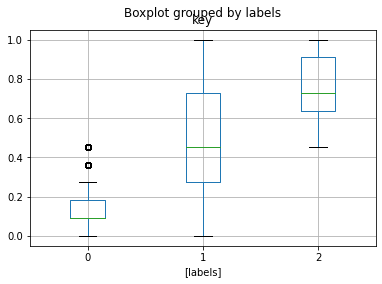

In [ ]:
df[['key','labels']].boxplot(by='labels')

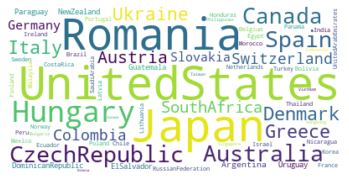

In [ ]:
text = " ".join([x.replace(" ","") for x in df_0.country])
word_cloud = WordCloud(collocations=False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

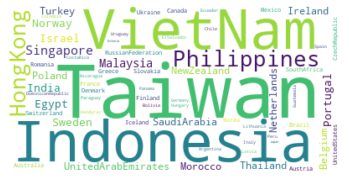

In [ ]:
text = " ".join([x.replace(" ","") for x in df_1.country])
word_cloud = WordCloud(collocations=False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

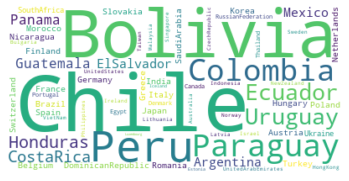

In [ ]:
text = " ".join([x.replace(" ","") for x in df_2.country])
word_cloud = WordCloud(collocations=False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
pca = PCA(n_components = 2)
W_1 = pca.fit_transform(df.iloc[:,1:-2])
weights = np.array(df.weights)

In [ ]:
silhouette, sse_list, kn = find_optimal_clusters(fit, W_1,weights, 2, 20, 100,5, 'auto')
centroids, labels, score = fit(W_1, weights, kn, 100, 0)

iterations to converge:  15
iterations to converge:  27
iterations to converge:  9
iterations to converge:  13
iterations to converge:  13
iterations to converge:  16
iterations to converge:  15
iterations to converge:  11
iterations to converge:  34
iterations to converge:  20
iterations to converge:  14
iterations to converge:  16
iterations to converge:  32
iterations to converge:  35
iterations to converge:  25
iterations to converge:  18
iterations to converge:  32
iterations to converge:  18
iterations to converge:  22
Optimal clusters are  9
iterations to converge:  27


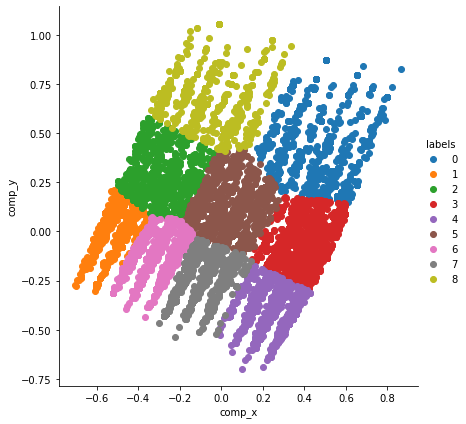

In [ ]:
pca_out_2 = pd.DataFrame(W_1, columns = ['comp_x','comp_y'])
pca_out_2['labels'] = labels
sns.FacetGrid(pca_out_2, hue='labels', height=6).map(plt.scatter,'comp_x','comp_y').add_legend()

In [ ]:
df

track_url  acousticness    energy  instrumentalness  \
0      5Z9KJZvQzH6PFmb8SNkxuk      0.022333  0.684038          0.000000   
1      5PjdY0CKGZdEuoNab3yDmX      0.038714  0.758925          0.000000   
2      0k1WUmIRnG3xU6fvvDVfRG      0.000613  0.587608          0.000005   
3      2BcMwX1MPV6ZHP4tUT9uq6      0.064194  0.410135          0.000000   
4      02MWAaffLxlfxAUY7c5dvx      0.444887  0.513746          0.000007   
...                       ...           ...       ...               ...   
12809  7y5HF80szyShYXpXTAwYtD      0.726994  0.656340          0.000357   
12810  3jsYQw78lrxJA2ysnmOIf9      0.421631  0.794830          0.000000   
12811  4S0uLMXRoAjFfIJOW7A8aW      0.241649  0.644030          0.000090   
12812  7qiZfU4dY1lWllzX7mPBI3      0.587457  0.644030          0.000000   
12813  2gT5LL3uRANxvvmDxaULbQ      0.883719  0.393722          0.000000   

            key  liveness  loudness  speechiness     tempo   valence  \
0      0.909091  0.034254  0.587044     0.059962  0.565748  0.908840   
1      0.090909  0.091758  0.671891     0.034206  0.676482  0.470002   
2      1.000000  0.320116  0.647427     0.160534  0.487172  0.314183   
3      0.454545  0.071414  0.490077     0.409921  0.542307  0.125503   
4      1.000000  0.080444  0.609022     0.097029  0.179443  0.526182   
...         ...       ...       ...          ...       ...       ...   
12809  0.454545  0.099024  0.574835     0.191878  0.620141  0.524062   
12810  0.090909  0.043180  0.788882     0.054102  0.308483  0.792241   
12811  0.454545  0.090720  0.614305     0.057645  0.398014  0.380962   
12812  0.090909  0.081482  0.774053     0.077678  0.263756  0.950180   
12813  0.272727  0.142620  0.526528     0.019896  0.415807  0.202883   

        weights  labels  
0      0.720046       1  
1      0.547235       3  
2      0.791475       6  
3      0.844470       3  
4      0.743088       2  
...         ...     ...  
12809  0.664747       0  
12810  0.625576       4  
12811  0.773041       3  
12812  0.816820       4  
12813  0.323733       0  

[12812 rows x 12 columns]

In [ ]:
fig = px.scatter(df, x="acousticness", y="track_url", color="labels",
                 size='acousticness', hover_data=['track_url'])
fig.show()

In [ ]:
# fig = px.scatter(W, x="acousticness", y="track_url", color="labels",
#                  size='acousticness', hover_data=['track_url'])
# fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of [0, 1, 2] but received: acousticness

# Library Function

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
km = KMeans(n_clusters=3, random_state=0)
km.fit_predict(W)
score = silhouette_score(W, km.labels_, metric='euclidean')

# Silhouette Score - Comparison

In [ ]:
print('Library Function -  Silhouette Score: %.3f' % score)
print('Custom Function - Silhouette Score: %.3f' % silhouette[2])

Library Function -  Silhouette Score: 0.359
Custom Function - Silhouette Score: 0.315
